In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras_preprocessing.image import ImageDataGenerator


from src.ml.eval import eval_model
from ml.pipeline import FeitDataPipeline
from tensorflow import keras

from tensorflow.keras.callbacks import ReduceLROnPlateau

from cfg import *

from livelossplot import PlotLossesKerasTF

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

name = "MySimpleCnn_Feit-reduced-rgb-no_inception-weighted_class_loss"


/home/jelinek/recetox/src/notebooks/MyCNN


In [2]:
class MySimpleCNNInceptionModule(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size=256


    @staticmethod
    def get_compiled_model():
        inputs = keras.Input(shape=(256, 256, 3))

        x = keras.layers.Conv2D(filters=16, kernel_size=5, strides=(1, 1), padding='same')(inputs)

        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=32, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=128, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=256, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = keras.layers.Conv2D(filters=512, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Flatten()(x)
        outputs = keras.layers.Dense(units=11, activation='softmax')(x)

        model = keras.Model(inputs, outputs, name='MySimpleCnnFewerLayers')
        model.summary()
        return model

    def get_data_loader_training(self):
        datagen_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True)

        return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=True,
                                                 target_size=(self.params.tile_size, self.params.tile_size))

    def get_data_loader_validation(self):
        datagen_valid = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
        return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=False,
                                                 target_size=(self.params.tile_size, self.params.tile_size))


    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        # Setting the class weights
        total = len(data_valid.classes)

        class_weights = {k : (total / 2.0) * 1.0 / len([x for x in data_train.classes if x == k])for k in data_train.class_indices.values()}

        print("Class weights: ")
        print(class_weights)
        print("***************************")

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()],
                       class_weight=class_weights)

In [3]:
pipeline = MySimpleCNNInceptionModule(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                                        valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

Model: "MySimpleCnnFewerLayers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64,

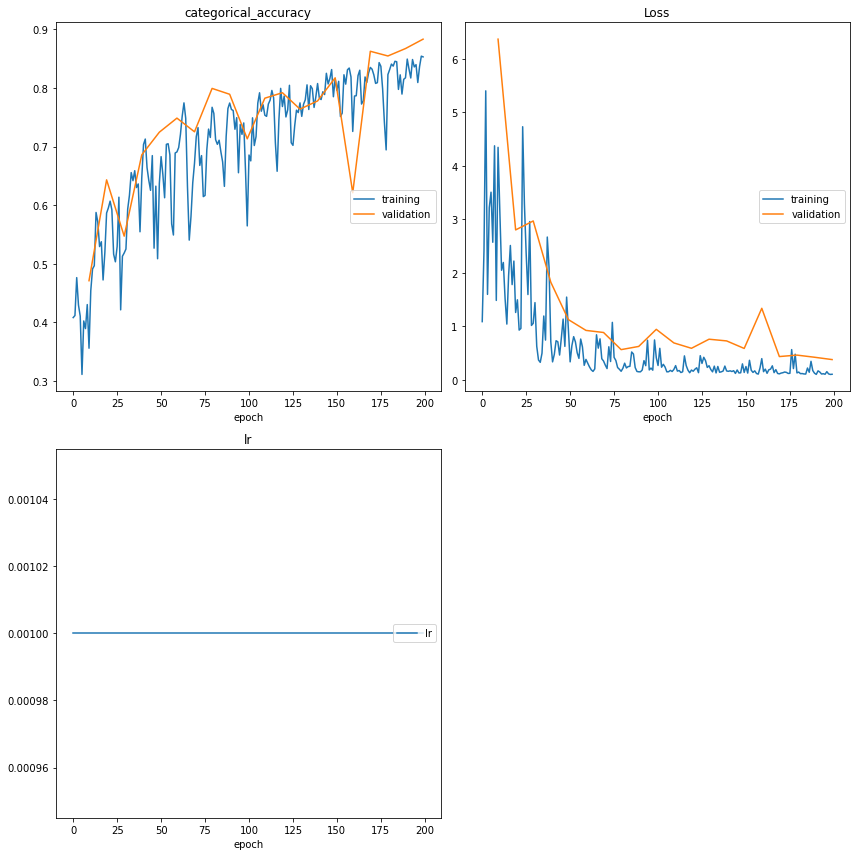

categorical_accuracy
	training         	 (min:    0.311, max:    0.854, cur:    0.853)
	validation       	 (min:    0.471, max:    0.883, cur:    0.883)
Loss
	training         	 (min:    0.103, max:    5.401, cur:    0.106)
	validation       	 (min:    0.380, max:    6.366, cur:    0.380)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
250/250 [==============================] - 20s 81ms/step - loss: 0.1058 - categorical_accuracy: 0.8530 - val_loss: 0.3801 - val_categorical_accuracy: 0.8833 - lr: 0.0010
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.7179ms
Confusion Matrix
[[300   5   1   0   3   1   0   0   0   0  25]
 [  1  45  10   1   0   0   7   0   0   0   0]
 [  0   7 104   0   2   0  24   6   0   0   2]
 [  0   0   0  11   0   0   0   0   0   0   0]
 [  0   3   4   3 533   0   0   0   0   0   1]
 [  0   0   0   0   0   1   0   0   0   0   0]
 [  0   6   7   0   0   0  59   4   1   0   0]
 [  0   1   3   0   0   0   7  75   0   0   0]
 [

In [4]:
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [5]:
pipeline.save_pipeline()

In [6]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           name,
           print_confusion_matrix=True,
           save_misclassified=True)

Found 1499 images belonging to 11 classes.
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.6963ms
Confusion Matrix
[[300   5   1   0   3   1   0   0   0   0  25]
 [  1  45  10   1   0   0   7   0   0   0   0]
 [  0   7 104   0   2   0  24   6   0   0   2]
 [  0   0   0  11   0   0   0   0   0   0   0]
 [  0   3   4   3 533   0   0   0   0   0   1]
 [  0   0   0   0   0   1   0   0   0   0   0]
 [  0   6   7   0   0   0  59   4   1   0   0]
 [  0   1   3   0   0   0   7  75   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0]
 [ 35   3   0   0   0   0   0   0   0   0 196]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.89      0.90      0.89       335
          blood_and_vessels       0.64      0.70      0.67        64
          connective_tissue       0.80      0.72      0.76       145
                      empty       0.73      1.0

In [7]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)

In [8]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1)

Processing region 120 out of 120
Post-processing image...
Processing grid point 663499 out of 663499
Processing image took 2233.080766916275 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no_inception-weighted_class_loss/ns-adenoca-colon-15071-2019-20x-he-4.tiff
----------------------------------------------------
Processing region 255 out of 255
Post-processing image...
Processing grid point 1599360 out of 1599360
Processing image took 5469.015362262726 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no_inception-weighted_class_loss/ns-adenoca-colon-15072-2019-20x-he-a2.tiff
----------------------------------------------------
Processing region 255 out of 255
Post-processing image...
Processing grid point 1544036 out of 1544036
Processing image took 5304.642511844635 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no_inception-weighted_class_loss/ns-adenoca-colon-3043-2019-20x-he-a1.tiff
-